In [1]:
import mira
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
mira.utils.wide_view()

In [2]:
import torch

In [3]:
_dir = '../../kladi/data/shareseq/2021-08-12_checkpoints/transfer_to_iris/'
rna_data = anndata.read_h5ad('../../kladi/data/shareseq/2021-08-12_checkpoints/rna_data.h5ad')
atac_data = anndata.read_h5ad('../../kladi/data/shareseq/2021-08-12_checkpoints/atac_data.h5ad')

In [4]:
rna_data.obs['hair_follicle'] = rna_data.obs.true_cell.isin(['Medulla','Cortex','Inner Matrix', 'Outer Matrix','ORS','IRS','Matrix'])
rna_data.obs['keratinocytes'] = rna_data.obs.true_cell.str.contains('Spinous|Granular|Basal|Bulge|Infandibulum|Isthmus')

In [5]:
rna_data = rna_data[rna_data.obs.hair_follicle | rna_data.obs.keratinocytes]
atac_data = atac_data[rna_data.obs_names]

atac_mod_data = torch.load(_dir + 'atac_model.pth')
rna_mod_data = torch.load(_dir + 'rna_model.pth')

def convert_model(mod, savename):
    
    mod['params']['endogenous_key'] = mod['params'].pop('highly_variable_key')
    mod['params']['exogenous_key'] = mod['params'].pop('predict_expression_key')
    mod['params'].pop('training_bar')

    torch.save(mod, savename)

convert_model(atac_mod_data, 'data/shareseq_atac_model.pth')
convert_model(rna_mod_data, 'data/shareseq_rna_model.pth')

In [2]:
atac_model = mira.topics.AccessibilityTopicModel.load('data/shareseq_atac_model.pth')
rna_model = mira.topics.ExpressionTopicModel.load('data/shareseq_rna_model.pth')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [7]:
import pandas as pd

In [8]:
tss_data = pd.read_csv('/Users/alynch/genomes/mm10/canonical_tss.tsv', sep = '\t')

tss_data.head(3)

tss_data.columns = tss_data.columns.str.split('.').str.get(-1) # parse the column titles to get rid of table name

tss_data.geneSymbol = tss_data.geneSymbol.str.upper() # make the gene symbols uppercase
tss_data = tss_data.dropna() # drop gene entries that do not correspond with the gene's canonical splice variant
tss_data = tss_data.drop_duplicates('geneSymbol') # drop duplicate gene symbols to remove ambiguity. Most gene symbols correspond to a unique locus, but some don't. 
                                                  # If you've done your whole analysis up to this point with Ensemble IDs you could potentially test specific loci for these genes.

In [9]:
mira.tl.get_distance_to_TSS(atac_data, # ATAC data
                    tss_data = tss_data, # annotation dataframe
                    peak_chrom='chr', # column from ATAC data with peak chromosome locs
                    peak_start= 'start',
                    peak_end = 'end',
                    gene_id = 'geneSymbol', # column from TSS data with gene name,
                    gene_chrom = 'chrom',
                    gene_strand = 'strand',
                    gene_start = 'txStart',
                    gene_end = 'txEnd',
                    genome_file= '/Users/alynch/genomes/mm10/mm10.genome' # chromosome lengths of genome
                   )

INFO:mira.tools.connect_genes_peaks:Finding peak intersections with promoters ...
INFO:mira.tools.connect_genes_peaks:Calculating distances between peaks and TSS ...
INFO:mira.tools.connect_genes_peaks:Masking other genes' promoters ...
INFO:mira.adata_interface.rp_model:Added key to var: distance_to_TSS
INFO:mira.adata_interface.rp_model:Added key to uns: distance_to_TSS_genes


In [10]:
lite_model = mira.rp.LITE_Model(accessibility_model=atac_model, expr_model=rna_model,
                               genes = ['RNASET2B','LEF1','KRT23','CASP14'])
rp_args = dict(expr_adata = rna_data, atac_adata = atac_data)

'''lite_model.fit(**rp_args)
lite_model.predict(**rp_args)'''

nite_model = mira.rp.NITE_Model(accessibility_model=atac_model, expr_model=rna_model,
                               genes = ['RNASET2B','LEF1','KRT23','CASP14'], initialization_model=lite_model)
'''nite_model.fit(**rp_args)
nite_model.predict(**rp_args)'''

lite_model.load('data/shareseq_rp/')
nite_model.load('data/shareseq_rp/')

lite_model.predict(**rp_args)
nite_model.predict(**rp_args)

INFO:mira.adata_interface.core:Added cols to obs: model_read_scale
Trying to set attribute `.obs` of view, copying.
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Predicting latent variables ...
Calculating softmax summary data: 100%|██████████| 49/49 [00:00<00:00, 102.93it/s]
INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
INFO:mira.adata_interface.topic_model:Fetching key X_topic_compositions from obsm
INFO:mira.topic_model.base:Predicting latent variables ...
Calculating softmax summary data: 100%|██████████| 49/49 [00:19<00:00,  2.51it/s]
INFO:mira.adata_interface.core:Added cols to obs: softmax_denom
Predicting expression: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s]
INFO:mira.adata_interface.core:Added layer: LITE_prediction
Predicting expression: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]
INFO:mira.adata_interface.core:Added layer: NITE_prediction


In [11]:
atac_data.write_h5ad(_dir + '/atac_data_kerats.h5ad')
rna_data.write_h5ad(_dir + '/rna_data_kerats.h5ad')

/Users/alynch/opt/miniconda3/envs/mira/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'highly_variable' as categorical


In [12]:
mira.tl.get_chromatin_differential(rna_data)

INFO:mira.adata_interface.core:Added layer: chromatin_differential


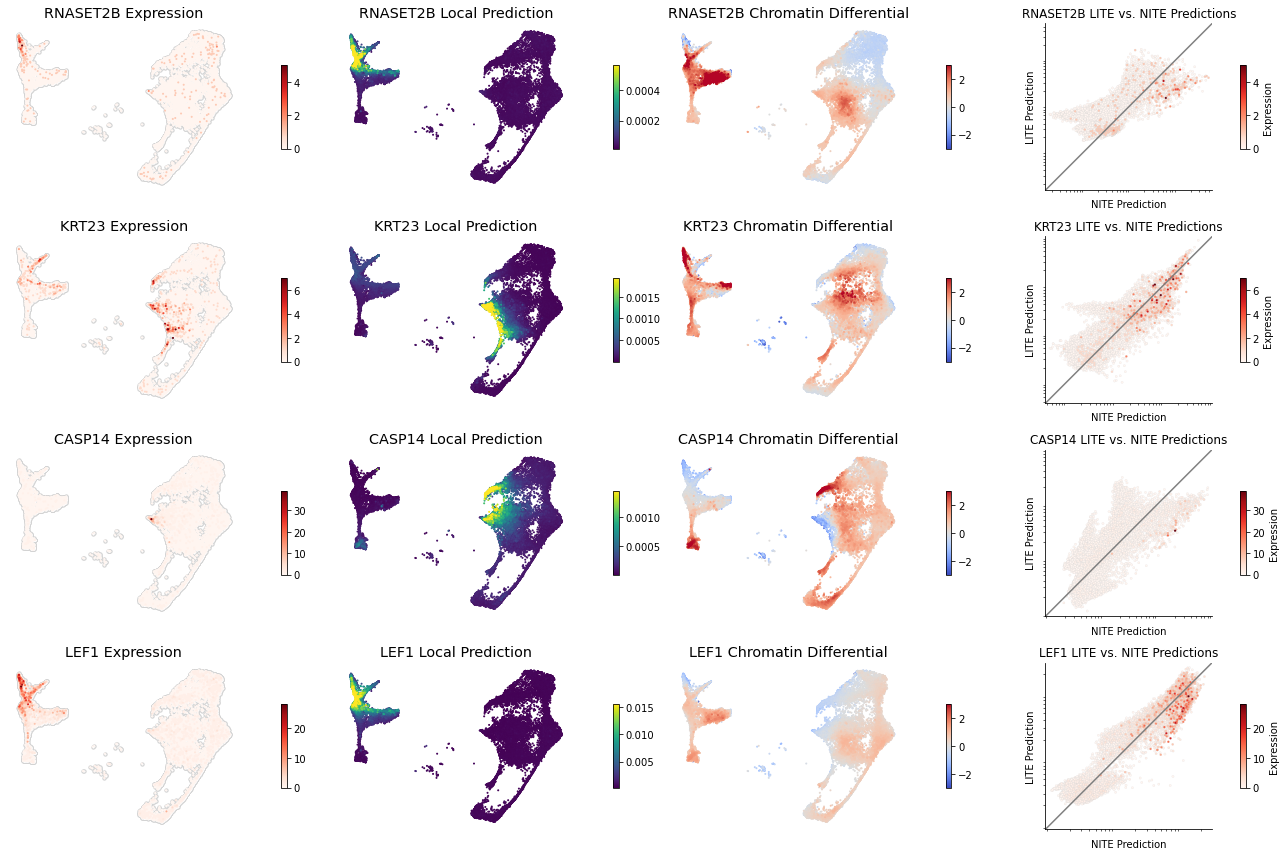

In [14]:
mira.pl.plot_chromatin_differential(rna_data, genes = ['RNASET2B','KRT23','CASP14','LEF1'])
plt.show()

In [1]:
!rm -rf data/shareseq/isd_checkpoint.h5

In [8]:
litemodel.probabilistic_isd(checkpoint='data/shareseq/isd_checkpoint.h5', **rp_args)

Predicting TF influence:   0%|          | 0/3 [00:00<?, ?it/s]


AttributeError: 'LITE_Model' object has no attribute 'gene'

In [1]:
import mira
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
mira.utils.wide_view()

DIR = '/Users/alynch/Dropbox (Partners HealthCare)/shareseq_code_ocean/'

rna_model = mira.topics.ExpressionTopicModel.load(DIR + 'shareseq_rna_model_rev1.pth')
atac_model = mira.topics.AccessibilityTopicModel.load(DIR + 'shareseq_atac_model_rev1.pth')
atac_model.encoder.calc_readdepth = False

rna_data = anndata.read_h5ad(DIR + 'lite_rna_data.h5ad')
atac_data = anndata.read_h5ad(DIR + 'lite_atac_data.h5ad')

with open(DIR + 'rp_model_genes.txt','r') as f:
    rp_genes = [x.strip() for x in f]

litemodel = mira.rp.LITE_Model(expr_model=rna_model, accessibility_model=atac_model, genes=['JAG1','KRT35','RNASET2B','LEF1'])
rp_args = dict(expr_adata = rna_data, atac_adata = atac_data)

#litemodel.fit(**rp_args, callback=mira.rp.SaveCallback(DIR + 'rp_models/'))
#litemodel.load(DIR + 'rp_models/')

INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu
INFO:mira.topic_model.base:Moving model to CPU for inference.
INFO:mira.topic_model.base:Moving model to device: cpu


In [9]:
litemodel.fit(**rp_args)

Fitting models: 100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


In [10]:
!rm -rf data/shareseq/isd_checkpoint.h5

In [5]:
litemodel.probabilistic_isd(**rp_args, checkpoint='data/shareseq/isd_checkpoint.h5')

Predicting TF influence: 100%|██████████| 4/4 [00:17<00:00,  4.38s/it]
INFO:mira.adata_interface.rp_model:Appending to expression adata:
INFO:mira.adata_interface.rp_model:Added key to varm: 'motifs-prob_deletion')
INFO:mira.adata_interface.rp_model:Added key to layers: motifs-informative_samples
INFO:mira.adata_interface.rp_model:Added key to uns: motifs


In [6]:
litemodel.load('../../kladi/data/shareseq/newcismodels/cis_models/')

In [8]:
rna_data.obs.softmax_denom

barcode
R1.01.R2.01.R3.43.P1.56     8521.269531
R1.01.R2.02.R3.21.P1.56     7182.193848
R1.01.R2.02.R3.38.P1.56    11381.546875
R1.01.R2.03.R3.28.P1.53     9096.184570
R1.01.R2.03.R3.61.P1.54     7738.817871
                               ...     
R1.96.R2.92.R3.27.P1.54     6397.393555
R1.96.R2.92.R3.28.P1.56     6625.390625
R1.96.R2.92.R3.83.P1.54    10174.931641
R1.96.R2.92.R3.85.P1.55    11279.869141
R1.96.R2.92.R3.86.P1.54     6694.978516
Name: softmax_denom, Length: 24653, dtype: float32

In [7]:
litemodel.get_model('LEF1').get_normalized_params()

{'a': array([0.24523532, 5.7879047 , 0.21273775], dtype=float32),
 'logdistance': array([37.19432 , 11.785375], dtype=float32),
 'theta': array(1.2140682, dtype=float32),
 'gamma': array(0.95974183, dtype=float32),
 'bias': array(1.6526564, dtype=float32),
 'bn_mean': array([0.79865795], dtype=float32),
 'bn_var': array([0.45453322], dtype=float32),
 'bn_eps': 1e-05}

In [6]:
mira.utils.fetch_ISD_matrix(rna_data).loc['JAG1'].sort_values().tail(25)

ASCL2            6.530968
PKNOX2           6.555325
KLF3             6.900090
HNF4A            6.901634
KLF13            6.920819
TCF7L2           7.205188
RUNX1            7.216444
KLF6             7.772922
ZKSCAN5          7.821983
SP3              7.850197
KLF9             8.123163
EWSR1-FLI1       8.198131
NFIX             8.507137
LHX2             9.257241
KLF5             9.274887
SP1              9.757344
KLF1            10.013105
KLF16           10.181872
PPARG::RXRA     11.069444
RREB1           11.081017
STAT1::STAT2    11.188920
KLF11           11.623751
RBPJ            11.824932
WT1             14.231981
KLF10           15.889167
Name: JAG1, dtype: float64